<a href="https://colab.research.google.com/github/hannahweber244/AAML_Code/blob/main/AAML_AudioKlassifizierung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import librosa
import librosa.display
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import cv2
import copy


from tqdm.notebook import tqdm
from google.colab import drive
from google.colab.patches import cv2_imshow

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
!gdown --id 1zEl7qyq5_NUIEZ3Qum9U_zHdCXNRTODq

Downloading...
From: https://drive.google.com/uc?id=1zEl7qyq5_NUIEZ3Qum9U_zHdCXNRTODq
To: /content/speechdat.zip
215MB [00:02, 77.7MB/s]


In [ ]:
!unzip speechdat.zip

Archive:  speechdat.zip
  inflating: README.txt              
   creating: speechdat/
   creating: speechdat/Actor_01/
  inflating: speechdat/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: speechdat/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: speechdat/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: speechdat/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: speechdat/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: speechdat/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: speechdat/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: speechdat/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: speechdat/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: speechdat/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: speechdat/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: speechdat/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: speechdat/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: speechdat/Actor_01/03-01-03-01-01-02-01.wav  
  inflating: speechdat/Actor_01/03-01-03-01-02-01-01.wa

In [ ]:
file = 'speechdat/Actor_01/03-01-01-01-01-01-01.wav'
y, sr = librosa.load(file)
S = librosa.feature.melspectrogram(y=y, sr=sr)

In [ ]:
S.shape

(128, 143)

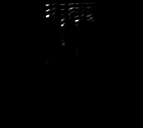

In [ ]:
cv2_imshow(S*255)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

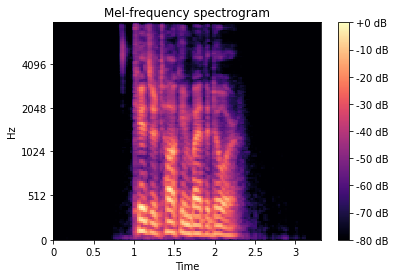

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

### Audio-Dateien einlesen

In [ ]:
read = open('README.txt').read()
read

'Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)\nSpeech audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo. Construction and perceptual validation of the RAVDESS is described in our Open Access paper in PLoS ONE.\n\nFiles\n\nThis portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.\n\nFile naming convention\n\nEach of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics

In [ ]:
data = list()
h,w = 64,64
path = 'speechdat'
artists = os.listdir(path)

classes = {'01' : 'neutral',
           '02' : 'calm', 
           '03' : 'happy', 
           '04' : 'sad', 
           '05' : 'angry', 
           '06' : 'fearful', 
           '07' : 'disgust', 
           '08' : 'surprised'}

classes_lookup = {i:key for i, key in enumerate(classes.keys())}

for artist in tqdm(artists):
    artist_path = os.path.join(path, artist)
    audios = os.listdir(artist_path)
    for audio in audios:
        file_path = os.path.join(artist_path, audio)
        label = audio.split('-')[2]
        y, sr = librosa.load(file_path)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        img = cv2.resize(S, (h,w))
        data.append((img,label))

In [ ]:
random.shuffle(data)#mischen der bilder

#80/20 Train-Test-Split
train_ = data[:int(len(data)*0.8)]
test_ = data[int(len(data)*0.8):]

In [ ]:
classes_id_lookup = {str(label):id for id, label in classes_lookup.items()}
num_classes = len(classes.keys())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def create_batches(data, batch_size = 64):
    '''
        data: liste, die bilder enthält
        batch_size: Anzahl Elemente in einem Batch
    '''
    batches = list()#liste enthält später alle erzeugten batches
    batch = list()#einzelner batch, der batch_size viele Elemente enthalten wird

    targets = list() #enthält alle batches mit targets 
    target = list()# wird behandelt wie ein einzlener batch, nur mit labeln

    random.shuffle(data)#Daten mischen, falls diese in irgendener Form geordnet sind
    for k, (d_, tar)  in enumerate(data, start = 1):#iteration über jedes Bild

        #label one-hot-encoden
        artist_id = classes_id_lookup[tar]#id des artist in lookup table auslesen
        label = np.zeros(num_classes)#vektor mit num_classes vielen 0en erzeugen
        label[artist_id] = 1
        label = torch.from_numpy(label).to(device)#one hot kodierung in tensor umwandeln

        if k % batch_size == 0:#jetziger batch ist mit diesem bild voll
            #if color:
            #    #img mit dimension (64, 64, 3), pytorch benötigt aber (3, 64, 64) --> permute (ändern der dimensionsreihenfolge)
            #    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)#/255 --> pixelnormalisierung auf [0,1]
            #else:
            #zusätzlich noch adaptiven histogrammausgleich machen, um kontraste zu erhöhen
            #img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))).unsqueeze(0).to(device)#mit unsqueeze dimension 1 vor 64,64 hinzufügen
            img = torch.from_numpy(copy.deepcopy(d_)).unsqueeze(0).to(device)
            batch.append(img)
            target.append(label)
            #bildtensoren mit hilfe von stack zusammenführen --> fügt batchdimension hinzu: (batchsize, color, 64,64)
            batch = torch.stack(batch)
            target = torch.stack(target)

            batches.append(batch)#batch in liste abspeichern
            targets.append(target)

            batch = list()#batch leeren
            target = list()
        else:#batch ist nicht voll --> mehr bilder hinzufügen
            #if color:
            #    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)
            #else:
            #img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))).unsqueeze(0).to(device)
            img = torch.from_numpy(copy.deepcopy(d_)).unsqueeze(0).to(device)
            batch.append(img)
            target.append(label)

    if len(batch) > 0:#kleinerer / letzter batch
        batch = torch.stack(batch)
        target = torch.stack(target)

        batches.append(batch)
        targets.append(target)
        batch = list()
    return batches, targets

In [ ]:
train_batches, train_targets = create_batches(train_)
test_batches, test_targets = create_batches(test_, batch_size = 1)

In [ ]:
train_batches[0].shape# Dimension N, C, H, W checken

torch.Size([64, 1, 64, 64])

In [ ]:
def train():
    model.train()
    epoch_loss = 0
    for batch_id, batch in enumerate(train_batches):
        target = train_targets[batch_id].float()#für batch entsprechende targets auslesen

        optimizer.zero_grad()#nullen der gradienten, um falsches Updaten der Parameter zu verhindern
        out = model(batch.float())#übergeben des aktuellen batches in model und berechnung eines output mittels forward pass
        #berechnen des loss und update der model parameter
        loss = criterion(out, target)
        loss.backward()#berechnung der gradienten eines jeden parameters
        optimizer.step()#updaten der parameter mit hilfe von adam optimizer
        epoch_loss += loss.item()#aufsummieren des loss zu avgloss
    return epoch_loss/len(train_batches)

def test():
    model.eval()
    epoch_loss = 0
    acc = 0
    with torch.no_grad():#rechenleistung sparen, da .backward() nicht benötigt wird
        for batch_id, batch in enumerate(test_batches):
            target = test_targets[batch_id].float()#für batch entsprechende targets auslesen
            out = model(batch.float())#übergeben des aktuellen batches in model und berechnung eines output mittels forward pass

            out_ = torch.argmax(out)
            tar_ = torch.argmax(target)
            if out_.cpu().detach().numpy() == tar_.cpu().detach().numpy():
                acc += 1
    acc = acc/len(test_batches)#accuracy berechnen
    print('Accuracy:', acc)
    return acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ArtistClassifier(nn.Module):

    def __init__(self, num_classes):
        super(ArtistClassifier, self).__init__()

        #convolution layer
        #if color:#anzahl farbchannel muss angepasst werden je nach farbeingabe
        #    self.cnn1 = nn.Conv2d(3, 12,kernel_size=4, stride=2)#buntes bild
        #else:
        self.cnn1 = nn.Conv2d(1, 12,kernel_size=4, stride=2)#graues bild

        self.cnn2 = nn.Conv2d(12, 32, kernel_size=3, stride=1)
        self.cnn3 = nn.Conv2d(32, 16, kernel_size=2, stride=1)
        self.cnn4 = nn.Conv2d(16, 4, kernel_size=4, stride=2)

        #normalisierungs- und dropout layer
        self.batch_norm1 = nn.BatchNorm2d(12)
        self.batch_norm2 = nn.BatchNorm1d(300)
        self.dropout = nn.Dropout(p = 0.15)

        #fully-connected-Layer
        #self.fc = nn.Linear(4*13*13, num_classes)
        self.fc1 = nn.Linear(4*13*13, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, num_classes)

    def forward(self,x):
        x = self.batch_norm1(F.relu(self.cnn1(x.float())))
        x = F.relu(self.cnn2(x))
        x = F.relu(self.cnn3(x))
        x = self.dropout(x)
        x = F.relu(self.cnn4(x))

        x = x.flatten(start_dim = 1)#erste dimension (0) nicht flatten, da dies die batch-dimension ist
        #x = F.softmax(self.fc(x))
        x = F.relu(self.fc2(self.batch_norm2(F.relu(self.fc1(x)))))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x))
        return x

In [ ]:
model = ArtistClassifier(num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log_df = pd.DataFrame(columns = ['epoche', 'loss', 'accuracy'])

for e in range(50):
    print('epoche', e+1)
    loss_ = train()
    acc_ = test()
    log_df.loc[len(log_df),:] = [e+1, loss_, acc_]

epoche 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.1840277777777778
epoche 2
Accuracy: 0.2013888888888889
epoche 3
Accuracy: 0.2013888888888889
epoche 4
Accuracy: 0.3298611111111111
epoche 5
Accuracy: 0.3368055555555556
epoche 6
Accuracy: 0.3229166666666667
epoche 7
Accuracy: 0.3854166666666667
epoche 8
Accuracy: 0.3715277777777778
epoche 9
Accuracy: 0.3194444444444444
epoche 10
Accuracy: 0.3541666666666667
epoche 11
Accuracy: 0.3958333333333333
epoche 12
Accuracy: 0.3888888888888889
epoche 13
Accuracy: 0.3923611111111111
epoche 14
Accuracy: 0.3993055555555556
epoche 15
Accuracy: 0.3854166666666667
epoche 16
Accuracy: 0.3888888888888889
epoche 17
Accuracy: 0.3715277777777778
epoche 18
Accuracy: 0.3923611111111111
epoche 19
Accuracy: 0.4027777777777778
epoche 20
Accuracy: 0.3333333333333333
epoche 21
Accuracy: 0.3229166666666667
epoche 22
Accuracy: 0.3923611111111111
epoche 23
Accuracy: 0.4236111111111111
epoche 24
Accuracy: 0.3888888888888889
epoche 25
Accuracy: 0.3819444444444444
epoche 26
Accuracy: 0.3958333333333333
epoc

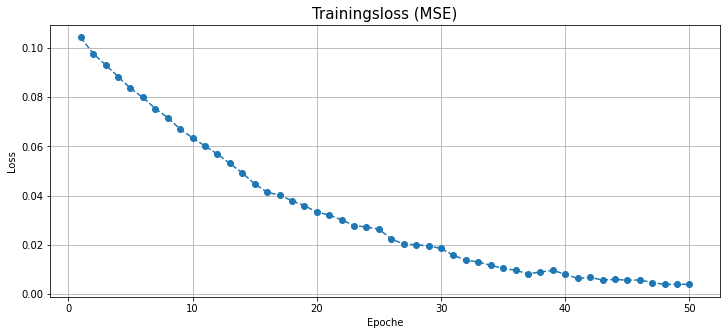

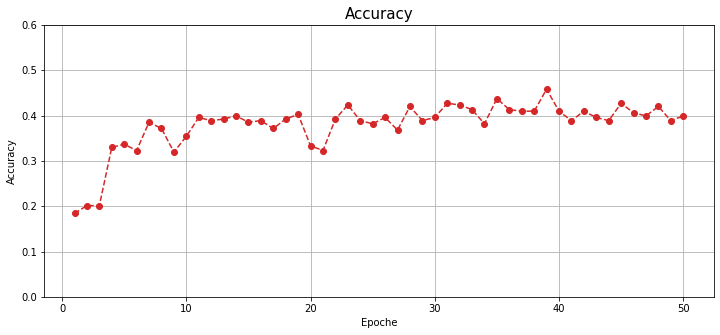

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(log_df.epoche, log_df.loss, '--', c='tab:blue')
plt.plot(log_df.epoche, log_df.loss, 'o', c='tab:blue')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.grid()
plt.title('Trainingsloss (MSE)', fontsize = 15)


plt.figure(figsize = (12,5))
plt.plot(log_df.epoche, log_df.accuracy, '--', c='tab:red')
plt.plot(log_df.epoche, log_df.accuracy, 'o', c='tab:red')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.ylim(0,0.6)
plt.grid()
plt.title('Accuracy', fontsize = 15);